In [7]:
from copy import deepcopy
import itertools, pandas as pd, tqdm.auto as tq
import matplotlib.pyplot as plt
import numpy as np
import simulation.runner as runner

In [8]:
def single_run(params: dict) -> dict:
    """Run one (moderately fast) Monte‑Carlo batch and return its JSON summary."""
    return runner.run(deepcopy(params), collect=True)

In [9]:
# ------- tunables -------------------------------
PARAMS = dict(
    topology    = ["chain", "ring", "star"],
    # node counts chosen so hop‑lengths ≈ link_length
    nodes       = { "chain":[3,5], "ring":[3,6], "star":[4] },
    link_length = [25, 50, 100],
    protocol    = ["dejmps", "bbpssw"],
    rounds      = [1, 2, 3],
    strategy    = ["purify_then_swap", "swap_then_purify"],
)
RUNS            = 200
FILTER_TH       = 0.5
COH_TIME        = 1.0
ATT_LEN         = 20000
MAX_TRIALS      = 200_000
# -----------------------------------------------

records = []
for topo in PARAMS["topology"]:
    nodes_list = PARAMS["nodes"][topo]
    grid = itertools.product(nodes_list, PARAMS["link_length"],
                             PARAMS["protocol"], PARAMS["rounds"],
                             PARAMS["strategy"])
    for n_nodes, L, proto, rnd, strat in tq.tqdm(list(grid),
                                                 desc=f"{topo} sweep"):
        p = dict(topology=topo, nodes=n_nodes, link_length=L,
                 protocol=proto, rounds=rnd, strategy=strat,
                 runs=RUNS, seed=42, filter_threshold=FILTER_TH,
                 coherence_time=COH_TIME, att_len=ATT_LEN,
                 max_trials=MAX_TRIALS)
        try:
            rec = single_run(p)
        except RuntimeError as e:
            print("Error", e)
            rec = {**p, "fidelity_mean":None, "latency_mean":None, "raw_mean":None}
        records.append(rec)

df = pd.DataFrame.from_records(records)
df["rate"] = df["raw_mean"] / df["latency_mean"]
print(f"{len(df)} parameter points collected")
df.head()

chain sweep:   0%|          | 0/72 [00:00<?, ?it/s]

ring sweep:   0%|          | 0/72 [00:00<?, ?it/s]

[   0.025 s]  trials=100  raw=310
[   0.050 s]  trials=100  raw=200
[   0.050 s]  trials=100  raw=265
[   0.050 s]  trials=100  raw=285
[   0.099 s]  trials=100  raw=285
[   0.099 s]  trials=100  raw=280


star sweep:   0%|          | 0/36 [00:00<?, ?it/s]

180 parameter points collected


,topology,nodes,link_length,protocol,rounds,strategy,runs,seed,filter_threshold,coherence_time,att_len,max_trials,latency_mean,fidelity_mean,raw_mean,timestamp,rate
0,chain,3,25,dejmps,1,purify_then_swap,200,42,0.5,1.0,20000,200000,0.000474,0.800097,3.04,1.746567e+09,6416.886544
1,chain,3,25,dejmps,1,swap_then_purify,200,42,0.5,1.0,20000,200000,0.000472,0.793873,2.86,1.746567e+09,6052.910053
2,chain,3,25,dejmps,2,purify_then_swap,200,42,0.5,1.0,20000,200000,0.000663,0.856280,4.28,1.746567e+09,6460.377358
3,chain,3,25,dejmps,2,swap_then_purify,200,42,0.5,1.0,20000,200000,0.000604,0.847740,3.89,1.746567e+09,6443.064182
4,chain,3,25,dejmps,3,purify_then_swap,200,42,0.5,1.0,20000,200000,0.000810,0.898956,5.23,1.746567e+09,6456.790123


In [10]:
df_ok = df.dropna(subset=["fidelity_mean"]).copy()
print(f"Usable points: {len(df_ok)} / {len(df)}")

Usable points: 180 / 180


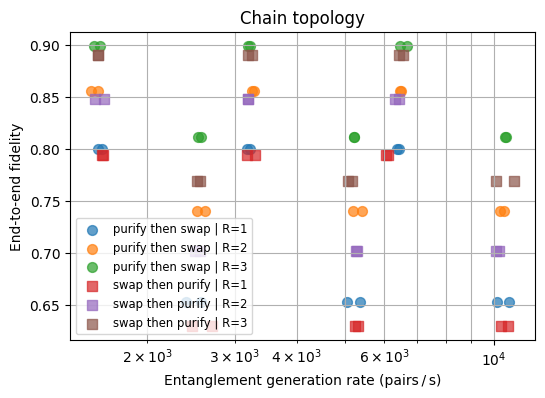

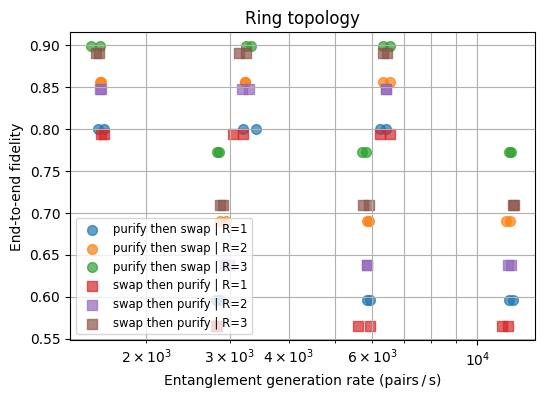

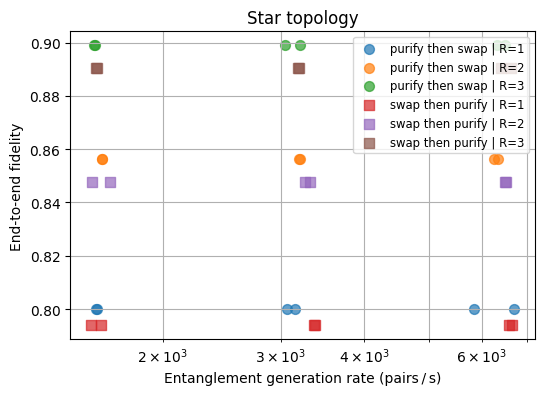

In [11]:
for topo, grp_topo in df_ok.groupby("topology"):
    fig, ax = plt.subplots(figsize=(6,4))
    for (strat, rnd), g in grp_topo.groupby(["strategy","rounds"]):
        ax.scatter(g["rate"], g["fidelity_mean"],
                   label=f"{strat.replace('_',' ')} | R={rnd}",
                   alpha=.7, s=50, marker='o' if strat.startswith("pur") else 's')
    ax.set_xscale("log"); ax.set_xlabel("Entanglement generation rate (pairs / s)")
    ax.set_ylabel("End‑to‑end fidelity")
    ax.set_title(f"{topo.capitalize()} topology")
    ax.legend(fontsize="small"); ax.grid(True, which="both")
    plt.show()

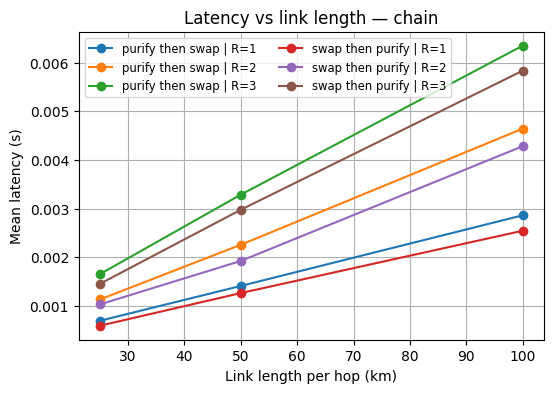

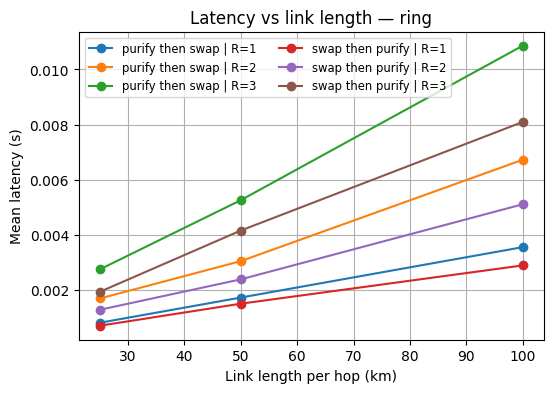

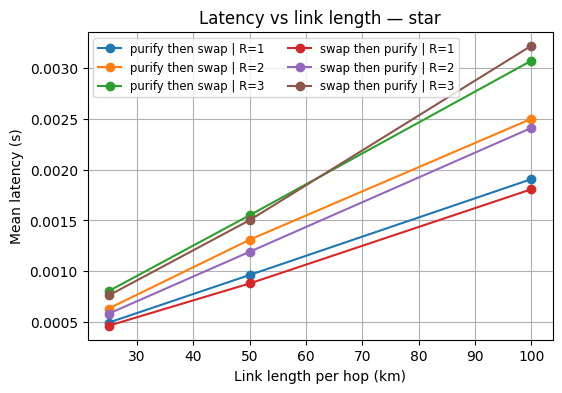

In [12]:
for topo, grp_topo in df_ok.groupby("topology"):
    fig, ax = plt.subplots(figsize=(6,4))
    for (strat, rnd), g in grp_topo.groupby(["strategy","rounds"]):
        piv = g.pivot_table(index="link_length", values="latency_mean",
                            aggfunc="mean")
        ax.plot(piv.index, piv.values,
                label=f"{strat.replace('_',' ')} | R={rnd}",
                marker='o')
    ax.set_xlabel("Link length per hop (km)")
    ax.set_ylabel("Mean latency (s)")
    ax.set_title(f"Latency vs link length — {topo}")
    ax.grid(True); ax.legend(fontsize="small", ncol=2)
    plt.show()

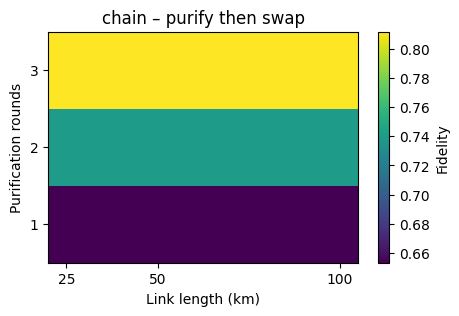

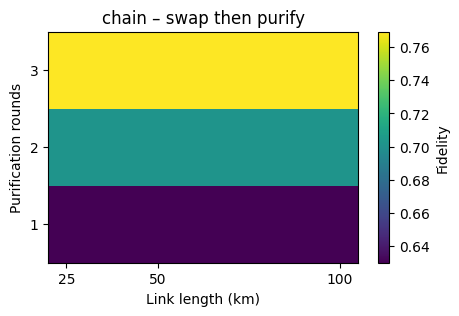

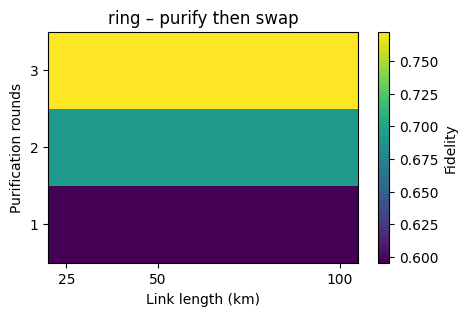

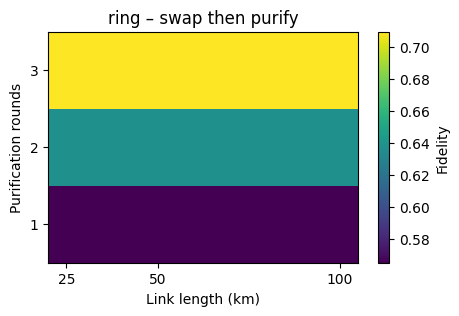

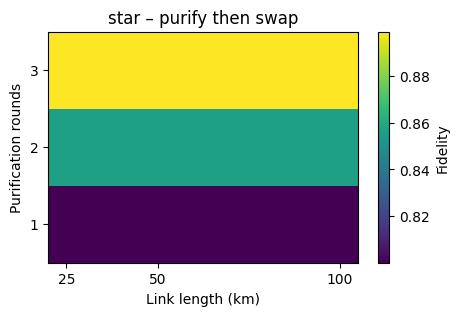

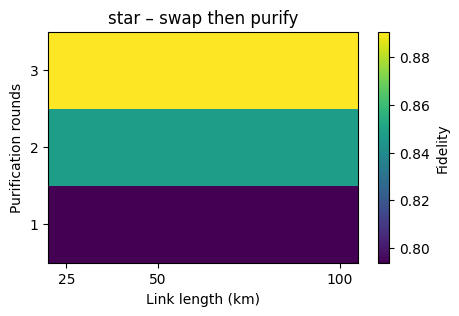

In [13]:
def heatmap(data, title):
    rounds = sorted(data["rounds"].unique())
    links  = sorted(data["link_length"].unique())
    M = np.full((len(rounds), len(links)), np.nan)
    for (r, L), val in data.set_index(["rounds","link_length"])["fidelity_mean"].items():
        M[rounds.index(r), links.index(L)] = val
    fig, ax = plt.subplots(figsize=(5,3))
    im = ax.imshow(M, origin="lower", aspect="auto",
                   extent=[min(links)-5, max(links)+5,
                           min(rounds)-.5, max(rounds)+.5])
    ax.set_xticks(links); ax.set_yticks(rounds)
    ax.set_xlabel("Link length (km)"); ax.set_ylabel("Purification rounds")
    plt.colorbar(im, ax=ax, label="Fidelity")
    ax.set_title(title); plt.show()

for (topo, strat), grp in df_ok.groupby(["topology","strategy"]):
    heatmap(grp, f"{topo} – {strat.replace('_',' ')}")
